In [ ]:
!nvidia-smi


Thu Jan 30 17:41:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# SAM Prompted Segmentation

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"  # Force UTF-8 encoding

In [ ]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-ii3_00f9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-ii3_00f9
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2025-01-30 17:52:20--  https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1058188 (1.0M) [image/jpeg]
Saving to: ‘images/cars.jpg.1’

cars.

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


using device: cuda


In [ ]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

## Segmentation

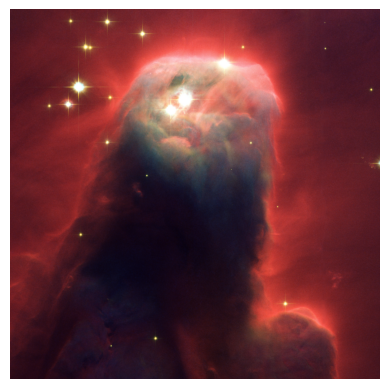

In [ ]:
import cv2


img = Image.open("heic0206c.tif")
im = np.array(img)  # shape is (6200, 6200, 3)

#im = np.squeeze(np.array(im), axis=0)

# Define the crop size (adjust as needed)
crop_size = (3000, 3000)  # (height, width)

# Calculate the center coordinates and crop bounds
center_y, center_x = im.shape[0] // 2, im.shape[1] // 2
start_y = center_y - crop_size[0] // 2
start_x = center_x - crop_size[1] // 2

# Crop the region from the center
cropped_im = im[start_y:start_y + crop_size[0], start_x:start_x + crop_size[1]]
im = np.array(cropped_im)
# load dome image
img = im
img = img.astype(np.uint8)
#img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#sr = cv2.dnn_superres.DnnSuperResImpl_create() # instantiate upscaler object
#path = "EDSR_x2.pb" # path to model
#sr.readModel(path) # loading model into upscaler object
#sr.setModel("edsr", 2) # setting model in upscaler object
result = img # upsampling image
plt.axis("off")
plt.imshow(result, cmap='gray')
#plt.savefig("test.png", dpi=2000, bbox_inches='tight', pad_inches=0)

plt.show()

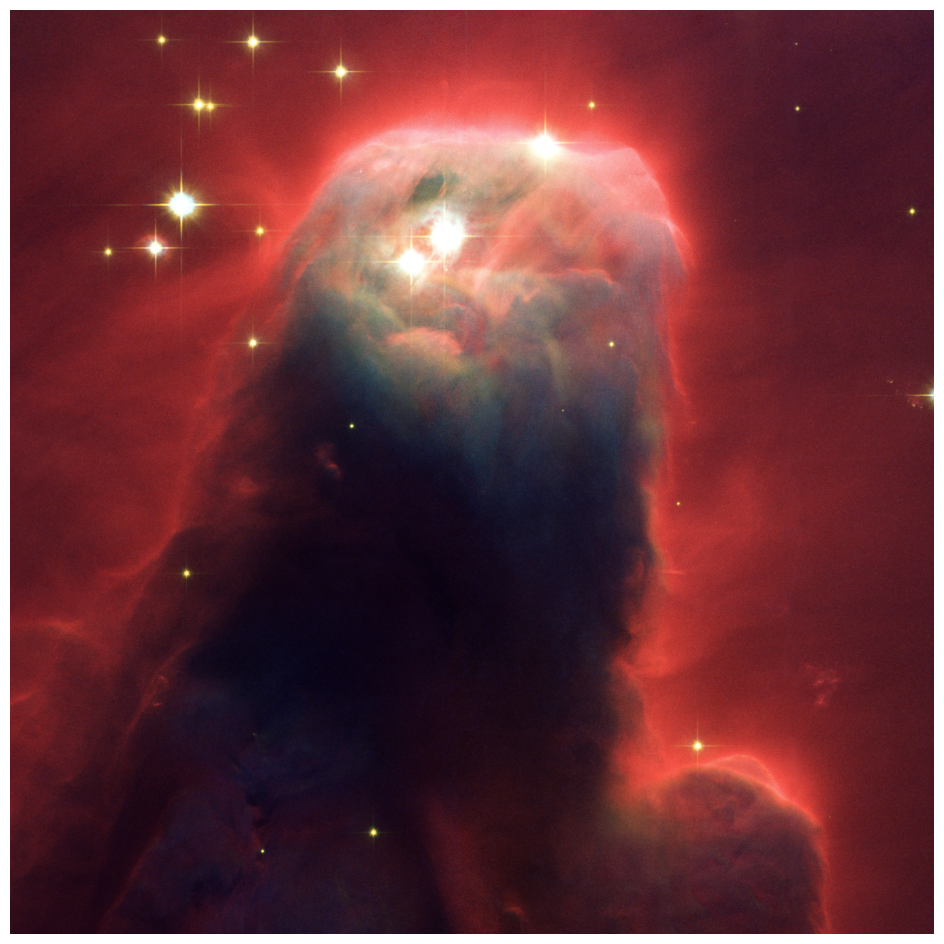

In [ ]:
image = result
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
from functools import wraps

def filter_masks_by_area(min_area=0, max_area=float('inf')):
    def decorator_generate(generate_func):
        @wraps(generate_func)
        def wrapper(*args, **kwargs):
            masks = generate_func(*args, **kwargs)  # Call the original generate function
            # Filter masks by area
            filtered_masks = [
                mask for mask in masks
                if min_area <= mask['area'] <= max_area
            ]
            return filtered_masks
        return wrapper
    return decorator_generate


In [ ]:
def getPts(imaniso, min_neuron=50, otsu_corr=1.25, min_neuron_brightness=200):
    from skimage import filters, morphology
    from skimage.feature import peak_local_max
    import math

    # Detect bright regions (white centroids)
    mask = imaniso > max(min_neuron_brightness, filters.threshold_otsu(imaniso) * otsu_corr)
    mask = morphology.remove_small_objects(mask, min_size=min_neuron, connectivity=1)

    # Find local maxima in the original (bright) image
    coordinates = peak_local_max(
        imaniso,
        min_distance=int(math.ceil(math.sqrt(min_neuron / 3.14)))*20
    )

    return coordinates[[mask[tuple(x)] for x in coordinates]]


def anisodiff(im, niter=12, delta=1.0/7.0, kappa=11, shRes=0):
    import numpy as np
    from scipy import ndimage

    im = im.astype('float64')
    u = im.copy()

    dx, dy, dd = 1, 1, np.sqrt(2)

    # Finite difference windows (unchanged)
    hN = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]], np.float64)
    hS = np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]], np.float64)
    hE = np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]], np.float64)
    hW = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]], np.float64)
    hNE = np.array([[0, 0, 1], [0, -1, 0], [0, 0, 0]], np.float64)
    hSE = np.array([[0, 0, 0], [0, -1, 0], [0, 0, 1]], np.float64)
    hSW = np.array([[0, 0, 0], [0, -1, 0], [1, 0, 0]], np.float64)
    hNW = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]], np.float64)

    masks = [hN, hS, hE, hW, hNE, hSE, hSW, hNW]

    if shRes > 0:
        ir, jr = u.shape
        varsmall = np.zeros((int(ir/shRes)+1, int(jr/shRes)+1))
        for i in range(int(ir/shRes)):
            for j in range(int(jr/shRes)):
                sub_u = u[i*shRes:min(ir, i*shRes+shRes), j*shRes:min(jr, j*shRes+shRes)]
                varsmall[i, j] = ndimage.laplace(sub_u).std()
        varsmall /= varsmall.max()

    for _ in range(niter):
        PM = sum(
            [np.exp(-(ndimage.convolve(u, m)/kappa)**2) * ndimage.convolve(u, m) for m in masks[:4]]
        ) + 0.5 * sum(
            [np.exp(-(ndimage.convolve(u, m)/kappa)**2) * ndimage.convolve(u, m) for m in masks[4:]]
        )

        if shRes > 0:
            for i in range(int(ir/shRes)):
                for j in range(int(jr/shRes)):
                    slice_i = slice(i*shRes, min(ir, i*shRes+shRes))
                    slice_j = slice(j*shRes, min(jr, j*shRes+shRes))
                    PM[slice_i, slice_j] *= varsmall[i, j]

        u += delta * PM

    return u

18


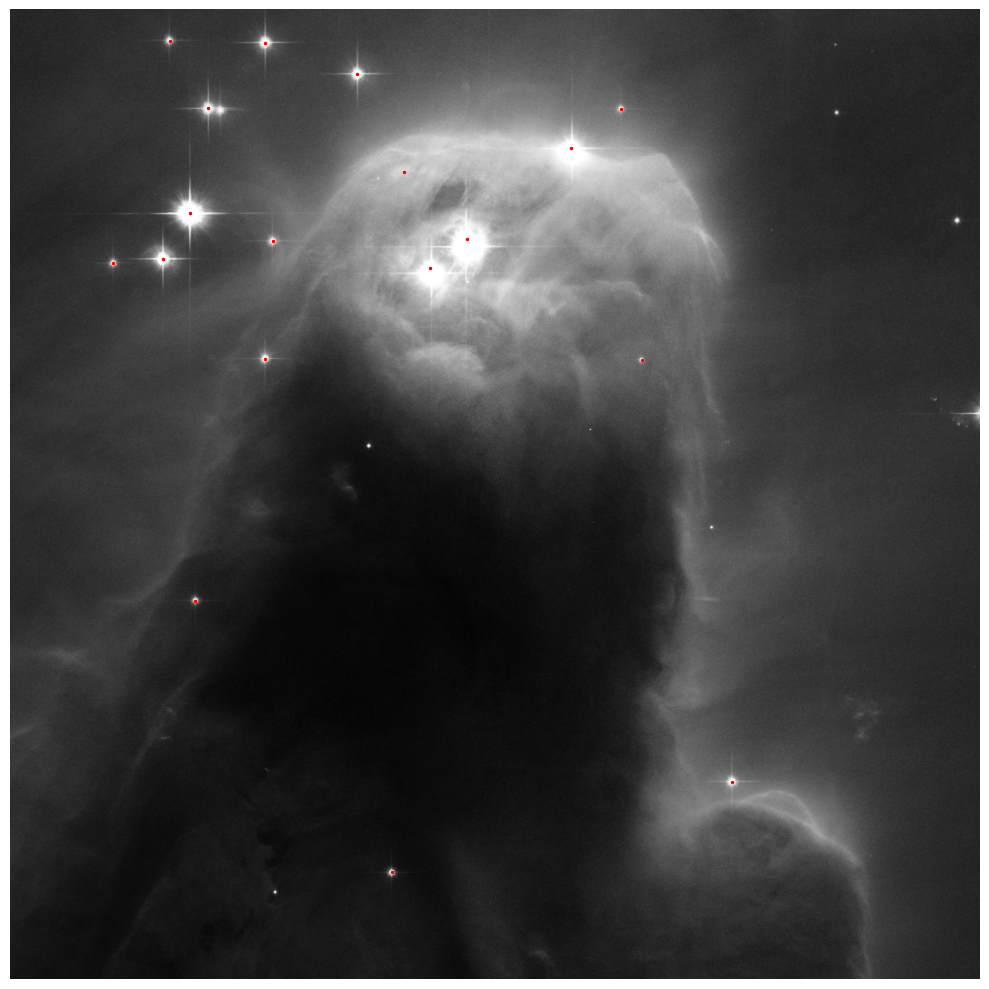

Mask bbox: [1261.0, 772.0, 88.0, 98.0], Area: 5836, Predicted IoU: 0.9375
Mask bbox: [516.0, 586.0, 85.0, 89.0], Area: 5077, Predicted IoU: 0.91796875
Mask bbox: [1364.0, 670.0, 112.0, 124.0], Area: 9613, Predicted IoU: 0.91015625
Mask bbox: [1692.0, 397.0, 89.0, 88.0], Area: 5166, Predicted IoU: 0.87890625
Mask bbox: [513.0, 561.0, 91.0, 124.0], Area: 5805, Predicted IoU: 0.8671875
Mask bbox: [1941.0, 1071.0, 23.0, 25.0], Area: 440, Predicted IoU: 0.86328125
Mask bbox: [1165.0, 2651.0, 33.0, 37.0], Area: 908, Predicted IoU: 0.85546875
Mask bbox: [1878.0, 297.0, 21.0, 22.0], Area: 381, Predicted IoU: 0.83984375
Mask bbox: [1690.0, 339.0, 94.0, 153.0], Area: 6187, Predicted IoU: 0.8046875
Mask bbox: [557.0, 1812.0, 34.0, 38.0], Area: 834, Predicted IoU: 0.796875
Mask bbox: [2209.0, 2306.0, 45.0, 159.0], Area: 2508, Predicted IoU: 0.78515625
Mask bbox: [588.0, 238.0, 80.0, 137.0], Area: 3290, Predicted IoU: 0.77734375
Mask bbox: [795.0, 698.0, 30.0, 38.0], Area: 828, Predicted IoU: 0.777

In [ ]:
import cv2
import numpy as np
import torch
from skimage import filters, morphology
from skimage.feature import peak_local_max
import math
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Load SAM model with provided configuration and checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(
    sam2,
    pred_iou_thresh=0.1,          # Lower IoU threshold
    stability_score_thresh=0.1    # Lower stability threshold
)
mask_generator.generate = filter_masks_by_area(min_area=0, max_area=50000)(mask_generator.generate)



# Load and process the image
gray_image = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

processed_image = anisodiff(gray_image, niter=12, delta=1.0/7.0, kappa=11, shRes=0)

# Generate centroids as prompts
centroids = getPts(processed_image, min_neuron=50, otsu_corr=0.65)
print(len(centroids))
# Plot the full image with all detected points
plt.figure(figsize=(10, 10))
plt.imshow(gray_image, cmap='gray')
plt.plot(centroids[:, 1], centroids[:, 0], 'r.', markersize=3)
plt.axis("off")
plt.tight_layout()
plt.show()
# Convert centroids to normalized points within [0, 1] for SAM2
height, width = image.shape[:2]
point_prompts =  [[float(x[1]) / width, float(x[0]) / height] for x in centroids]  # normalize coordinates

# Generate masks using SAM2AutomaticMaskGenerator with centroids as prompts
mask_generator.point_grids = [np.array(point_prompts)]  # set point grid to our centroids

masks = mask_generator.generate(image)

# Display mask information
for mask in masks:
    print(f"Mask bbox: {mask['bbox']}, Area: {mask['area']}, Predicted IoU: {mask['predicted_iou']}")
print(len(masks))

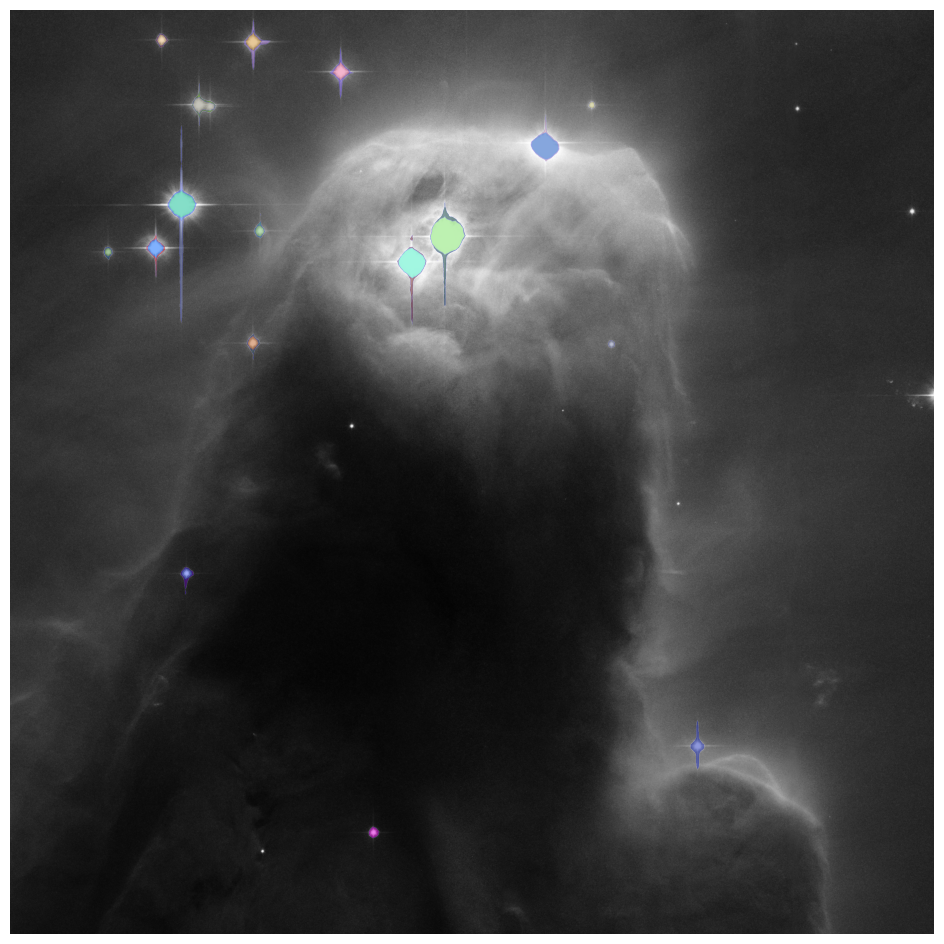

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(gray_image, cmap='gray')
show_anns(masks)
plt.axis('off')
plt.show()

## Segmentation